# Week 1 Seminar

A/B experiment analysis

In [88]:
import glob
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

In [89]:
experiment = "DIFM"

In [90]:
data = pd.concat([
    pd.read_json(data_path, lines=True)
    for data_path
    in glob.glob("C:/Users/EGodzun/Desktop/data/*/data.json")
])

data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

In [91]:
data

,message,timestamp,user,track,time,latency,recommendation,experiments,treatment
0,next,2025-04-30 12:56:33.243,8392,12710,1.00,9.084e-04,9096.0,{'DIFM': 'C'},C
1,next,2025-04-30 12:56:33.246,6947,39062,1.00,9.356e-04,37371.0,{'DIFM': 'C'},C
2,next,2025-04-30 12:56:33.306,8392,9096,0.03,8.638e-04,9097.0,{'DIFM': 'C'},C
3,next,2025-04-30 12:56:33.309,6947,37371,0.10,1.431e-03,37371.0,{'DIFM': 'C'},C
4,next,2025-04-30 12:56:33.364,7878,8147,0.00,6.275e-04,15799.0,{'DIFM': 'C'},C
...,...,...,...,...,...,...,...,...,...
9956,next,2025-04-30 13:03:21.197,4221,34320,0.80,1.759e-03,31268.0,{'DIFM': 'T1'},T1
9957,next,2025-04-30 13:03:21.316,4221,30258,0.51,1.498e-03,35380.0,{'DIFM': 'T1'},T1
9958,next,2025-04-30 13:03:21.441,4221,27191,0.41,3.850e-03,21563.0,{'DIFM': 'T1'},T1
9959,next,2025-04-30 13:03:21.571,4221,10813,0.04,3.950e-03,6718.0,{'DIFM': 'T1'},T1


In [92]:
data.groupby("treatment").count()

,message,timestamp,user,track,time,latency,recommendation,experiments
treatment,,,,,,,,
C,9370,9370,9370,9370,9370,9370,8185,9370
T1,10551,10551,10551,10551,10551,10551,9336,10551


## Visualize sessions

In [93]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)

        session = session._replace(
            tracks = session.tracks + 1,
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )

        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

In [94]:
sessions = (
    data
    .groupby(["user", "treatment"])
    .apply(sessionize)
    .explode()
    .apply(pd.Series)
)

C:\Users\EGodzun\AppData\Local\Temp\ipykernel_26708\2354129256.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sessionize)


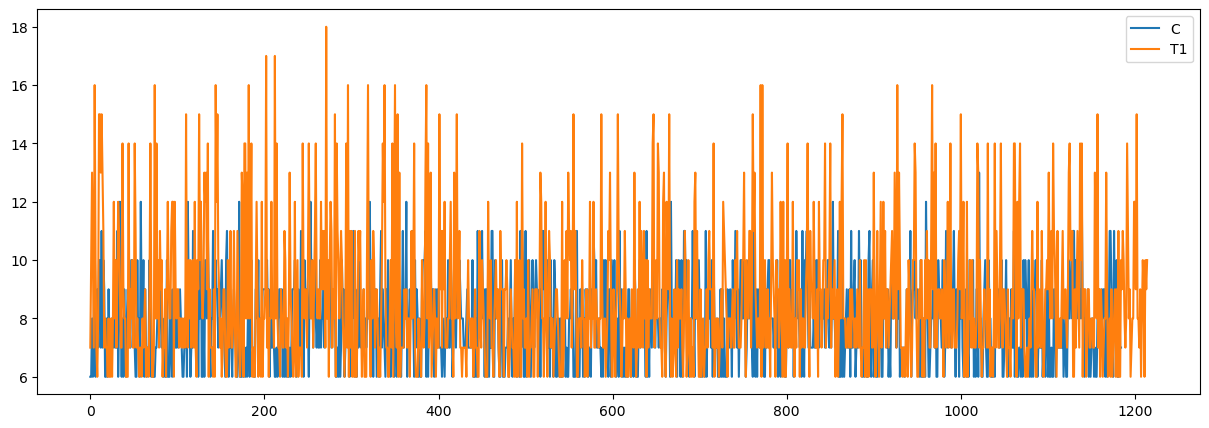

In [95]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass

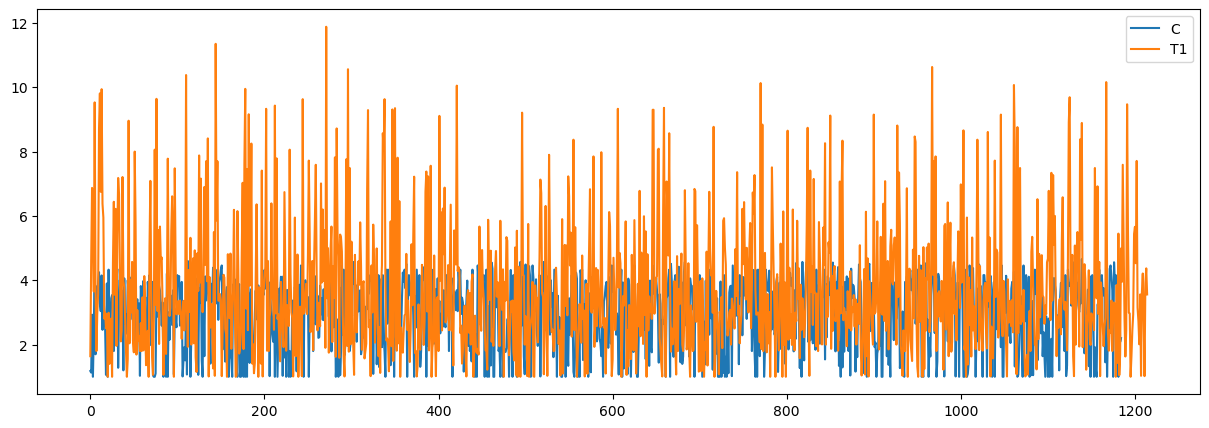

In [96]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass

## Analyze the experiment

In [97]:
user_level_data = (
  sessions
    .reset_index()
    .groupby(["user", "treatment"])
    .agg(
        {
            "timestamp": "count",
            "tracks": "sum",
            "time": "sum",
            "latency": "sum"
        }
    )
)

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = [
    "time",
    "sessions",
    "mean_request_latency",
    "mean_tracks_per_session",
    "mean_time_per_session"
]

user_level_metrics = user_level_data[metrics].copy().reset_index()

In [98]:
treatment_level_metrics = (
    user_level_metrics
    .groupby("treatment")[metrics]
    .agg(["count", "mean", "var"])
)

In [99]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

for treatment, row in treatment_level_metrics.iterrows():
    if treatment == "C":
        continue

    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]

        effect = treatment_mean - control_mean
        conf_int = ci(
            control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"],
        )
        effects.append({
            "treatment": treatment,
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

In [100]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'


(
    pd.DataFrame(effects)[[
        "treatment",
        "metric",
        "effect",
        "upper",
        "lower",
        "control_mean",
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

C:\Users\EGodzun\AppData\Local\Temp\ipykernel_26708\3787895724.py:9: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  pd.DataFrame(effects)[[


,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,24.555467,30.230343,18.880591,3.350238,4.172905,True
1,T1,sessions,-0.408670,2.296386,-3.113726,1.128571,1.123959,False
3,T1,mean_tracks_per_session,9.695185,11.762540,7.627830,7.903492,8.669750,True
4,T1,mean_time_per_session,25.082045,29.724081,20.440008,2.959726,3.702086,True
2,T1,mean_request_latency,64.603086,67.139262,62.066910,0.797566,1.312818,True
